# SARIMA

[*********************100%***********************]  1 of 1 completed


C:\Users\snapt\anaconda3\envs\mini_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\snapt\anaconda3\envs\mini_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Train MSE: 75.58
Test MSE: 2013.72


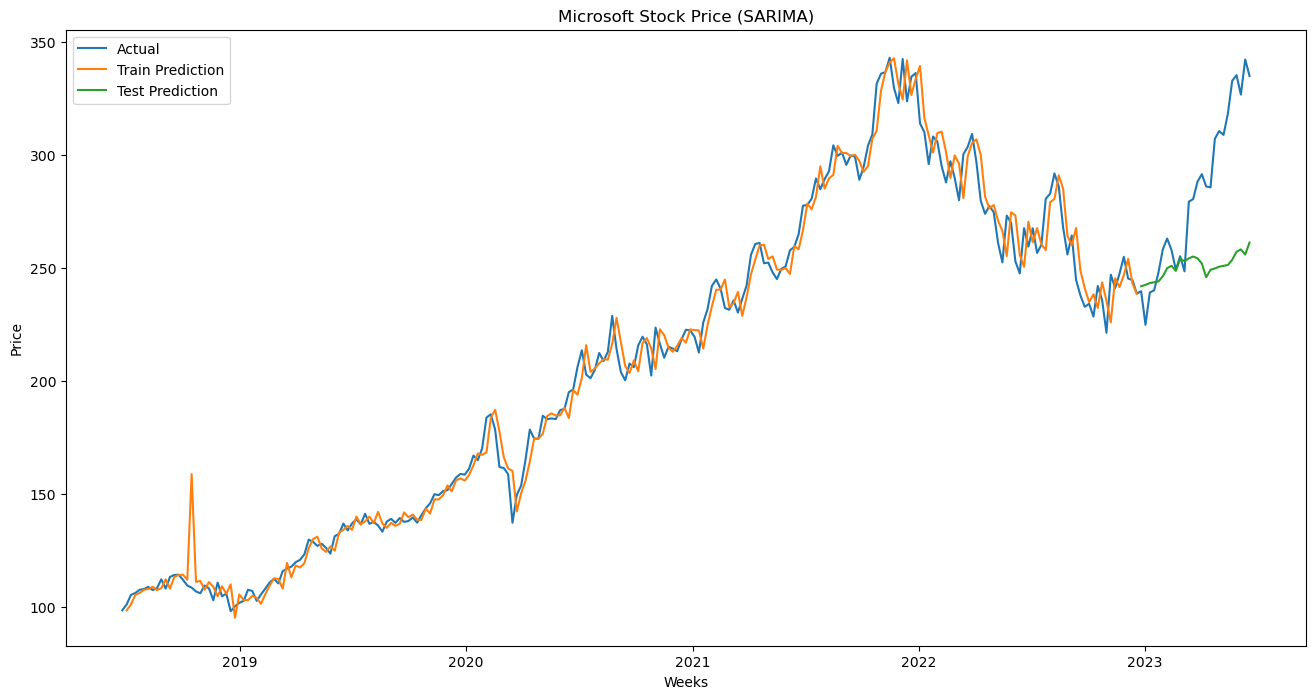

In [74]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetching the data
df = yf.download(tickers=['MSFT'], period='5y', interval='1wk')
df = df['Close']

# Splitting the data into training and test sets
train_size = len(df) - 26
train, test = df[0:train_size], df[train_size:]

# Building the SARIMAX model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 16))

# Training the model
model_fit = model.fit(disp=False)

# Making predictions
trainPredict = model_fit.predict(start=1, end=train_size - 1) # start from 1
testPredict = model_fit.predict(start=train_size, end=len(df) - 1) # ends at len(df) - 1

# Calculate MSE
trainScore = mean_squared_error(train[1:], trainPredict)
print('Train MSE: %.2f' % (trainScore))
testScore = mean_squared_error(test, testPredict)
print('Test MSE: %.2f' % (testScore))

# Visualizing the results
plt.figure(figsize=(16,8))
plt.plot(df)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.title('Microsoft Stock Price (SARIMA)')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.legend(['Actual','Train Prediction','Test Prediction'], loc='upper left')
plt.show()


# LSTM

[*********************100%***********************]  1 of 1 completed
Epoch 1/5
233/233 - 2s - loss: 0.0762 - 2s/epoch - 8ms/step
Epoch 2/5
233/233 - 1s - loss: 0.0125 - 1s/epoch - 5ms/step
Epoch 3/5
233/233 - 1s - loss: 0.0032 - 933ms/epoch - 4ms/step
Epoch 4/5
233/233 - 1s - loss: 0.0021 - 1s/epoch - 5ms/step
Epoch 5/5
233/233 - 1s - loss: 0.0020 - 1s/epoch - 4ms/step
1/1 [==============================] - 0s 13ms/step
Train MSE: 72.25
Test MSE: 134.55


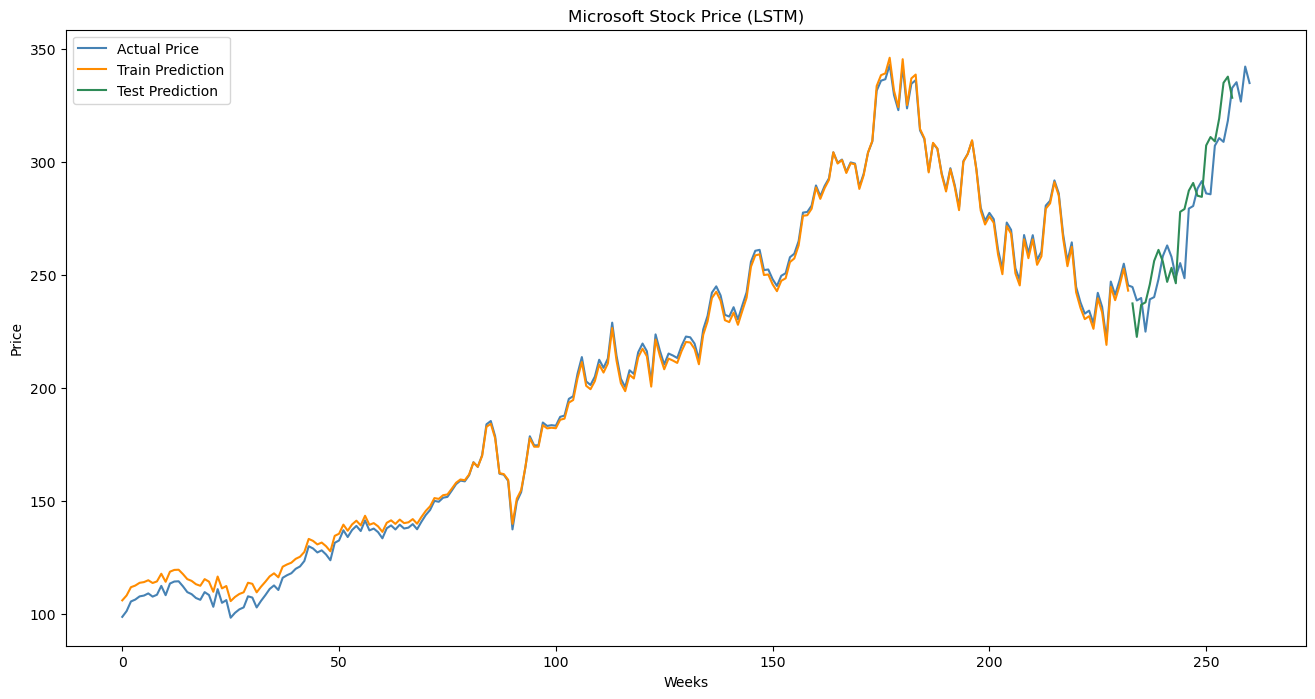

In [75]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetching the data
df = yf.download(tickers=['MSFT'], period='5y',interval='1wk')
df = df['Close'].values
df = df.reshape(-1,1)

# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)

# Splitting the data into training and test sets
train_size = len(df) - 26
train, test = df[0:train_size,:], df[train_size:len(df),:]

# Function to create dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshaping the data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Building the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the model
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# Making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverting predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate MSE
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train MSE: %.2f' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test MSE: %.2f' % (testScore))

# Visualizing the results
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df), color = 'steelblue', label = 'Actual Price')
plt.plot(np.arange(len(trainPredict)), trainPredict, color = 'darkorange', label = 'Train Prediction')
plt.plot(np.arange(len(trainPredict), len(trainPredict) + len(testPredict)), testPredict, color = 'seagreen', label = 'Test Prediction')
plt.title('Microsoft Stock Price (LSTM)')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.legend()
plt.show()
